# Análise Preditiva com Inteligência Artificial - Visão Computacional

O objetivo dessa análise preditiva no Jupyter Notebook é criar um modelo de regressão logística para reconhecimento de imagens, contudo o desafio será criar um algoritmo sem um framework específico e para isso será feito um modelo com base em pacotes matématicos e de programação. 

O modelo precisa identificar qual classe pertence aquela imagem. A base de dados conta com 60.000 imagens 32x32 separadas por 10 categorias que são:
- Airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truch

A fonte dos dados é: https://www.cs.toronto.edu/~kriz/cifar.html

## 1. Carga de pacotes

In [1]:
# Versão da linguagem Python usada neste Jupyter Notebook
from platform import python_version
print('A versão da linguagem Python usada neste Jupyter Notebook é:', python_version())

A versão da linguagem Python usada neste Jupyter Notebook é: 3.9.13


In [2]:
# Carga dos Pacotes
import math
import pickle #carga no formato da fonte de dados
import random #gera valores aleatórios
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Versões dos pacotes usados neste Jupyter Notebook
%reload_ext watermark
%watermark -a "Lab02 - Visão Computacional" --iversions

Author: Lab02 - Visão Computacional

matplotlib: 3.5.2
numpy     : 1.21.5



## 2. Funções auxiliares para carga e preparação dos dados

In [4]:
# Função para carregar os dados
def carrega_dados(filename):
    
    # Caminho das imagens
    filename = 'cifar-10-batches-py/' + filename
    
    # Carrega as imagens
    with open(filename, mode = 'rb') as file: #mode rb porque os dados foram gravados em formato binário no disco
        data = pickle.load(file, encoding = 'bytes')
        
    # Carrega imagem no formato bruto
    raw_images = data[b'data']
    
    # Obtém os números de classe para cada imagem e converte para array(tensor) numpy
    y = np.array(data[b'labels'])
    
    # Converte as imagens brutas dos arquivos de dado em pontos flutuantes(melhora a precisão dos cálculos)
    raw_float = np.array(raw_images, dtype = float) / 255.0
    
    # Reshape da matriz para 4 dimensões
    images = raw_float.reshape([-1, 3, 32, 32])
    
    # Reordena os índices do array
    images = images.transpose([0 , 2, 3, 1])
    
    #Shape final
    X = images.reshape((images.shape[0], 3*32*32))
    
    return X, y

In [5]:
# Função para formatação dos dados
def formata_dados(X, Y, v0, v1):
    
    # Limites
    lg = max(v0,v1)
    
    # Lista de índices
    indices = []
    
    # Loop para extração dos índices
    for i in range(len(Y)):
        if Y[i] == v0 or Y[i] == v1:
            indices.append(i)
    
    # Squeeze dos tensores (ajuste do shape)
    X = np.squeeze(np.take(X, indices, axis = 0))
    Y = np.squeeze(np.floor(np.divide(np.take(Y, indices, axis = 0), lg)))
    
    return X, Y

## 3. Geração de Batchs de Imagens

In [6]:
# Valores para definir os dados que serão usados
bloco_start = 0
bloco_end = 3
TRAIN_BATCH = 1

In [7]:
# Carrega os dados
x_treino, y_treino = carrega_dados(f'data_batch_{TRAIN_BATCH}')

In [8]:
# Formata e prepara os dados
x_treino, y_treino = formata_dados(x_treino, y_treino, bloco_start, bloco_end)

In [9]:
# Visualiza dataset de treino
x_treino

array([[0.49019608, 0.49019608, 0.45490196, ..., 0.56470588, 0.45490196,
        0.3372549 ],
       [0.43137255, 0.40784314, 0.38039216, ..., 0.2       , 0.18823529,
        0.24313725],
       [0.98823529, 0.03137255, 0.16470588, ..., 0.98431373, 0.22745098,
        0.34509804],
       ...,
       [0.68235294, 0.70588235, 0.76862745, ..., 0.5254902 , 0.50196078,
        0.41960784],
       [0.82745098, 0.90196078, 0.92941176, ..., 0.85490196, 0.92156863,
        0.94901961],
       [0.07058824, 0.23137255, 0.05098039, ..., 0.22745098, 0.23137255,
        0.14509804]])

In [10]:
# Visualiza dataset de treino
y_treino

array([1., 1., 1., ..., 0., 0., 1.])

## 4. Construindo o modelo de regressão logística sem o uso do frameworks

### 4.1 Módulo de treinamento e otimização

In [11]:
# Função para treinamento do modelo
def fit(X, Y, epsilon, learning_rate, start, end, beta = 0, max = 2000):
    
    # Valores de X e Y
    X = X[start:end]
    Y = Y[start:end]
    
    # Número de pontos de dados
    data_points = X.shape[0]
    
    # Número de dimensões
    dimensions = X.shape[1]
    
    # Lista para armazenar o likelihood
    likelihood0 = []
    
    # Valores de controle
    delta = 0
    itr = 0
    itrs = []
    
    # Inicialização de beta(pesos) com valores randômicos
    if beta == 0:
        beta = []
        for i in range(dimensions):
            beta.append(random.random() * 0)
        beta = np.array(beta)
        
    # Otimização da função de perda com a descida do gradiente
    while True:
        
        # Calcula os gradientes
        grad = calcula_gradiente(beta, X, Y)
        
        # Atualiza beta com o novo valor do gradiente e ajusta o tamanho da mudança com a taxa de aprendizados
        beta = beta + (learning_rate * grad)
        
        # Calcula o log likelihood(erro do modelo)
        log = func_log_likelihood(beta, X, Y)
        
        # Inclui o valor na lista
        likelihood0.append(log)
        
        # Ajusta o número de iterações
        itr += 1
        itrs.append(itr)
        
        #Calcula a norma da matriz de gradientes
        delta = np.linalg.norm(grad)
        
        #Se alcançamos o limite, finaliza o treinamento
        if delta < epsilon or itr > max:
            break
            
    return beta, likelihood0, itrs

### 4.2 Módulo da função de perda com log likelihood

In [12]:
# Função para cálculo do log likelihood
def func_log_likelihood(beta, X, Y):
    
    # Calcula dados de entrada x matrix de pesos
    t = np.dot(X, beta.T)
    
    # Subtrai o bias(viés)
    w = np.subtract(Y, 1)
    
    # Calcula o peso w
    w = np.dot(w, t)
    
    # Prepara o valor do bias
    m = np.power(math.e, -t)
    
    # Adiciona o bias
    m = np.add(1, m)
    
    # Calcula o log likelihood
    z = np.log(m)
    
    # Soma os valores de z(erros do modelo)
    z = np.sum(z)
    
    return w - z

## 4.3 Módulo da descida do gradiente

In [13]:
# Função para cálculo do gradiente
def calcula_gradiente(beta, X, Y):
    
    # Retira o bias antes dos cálculos
    z = np.subtract(Y, 1)
    
    # Calcula o novo valor do peso w
    w = np.power(math.e, np.dot(-X, beta.T))
    
    # O valor de p é quanto deve ser modificado no valor do peso w(é a derivada)
    p = np.divide(w, np.add(1, w))
    
    # O valor de q é o tensor final
    q = z + p
    
    # calcula delta(quanto os pesos devem mudar na próxima passada)
    delta = np.dot(q, X)
    
    return delta

### 4.4 Módulo de teste do modelo(Previsões)

In [14]:
# Função de teste do modelo
def predict(X, Y, beta):
    
    # Calcula z(previsão bruta do modelo)
    z = np.dot(X, beta)
    
    # Função da Regressão Logística
    # Usamos o valor de z para fazer as previsões de y
    predY = (1/(1 + np.exp(-z)))
    
    # Arredonda o valor
    predY = np.around(predY)
    
    # Matrizes de acertos e erros do modelo
    acertos = [[], []]
    erros = [[], []]
    
    # Loop de previsões
    for i in range(len(X)):
        if predY[i] == Y[i]:
            acertos[int(Y[i])].append(i)
        else:
            erros[int(Y[i])].append(i)
            
    return acertos, erros

### 4.5 Módulo de avaliação do modelo

In [15]:
# Função de avaliação
def avalia_modelo(correct, incorrect, total):
    
    # Acertos do modelo
    correct = len(correct[0]), len(correct[1])
    
    # Erros do modelo
    incorrect = len(incorrect[0]), len(incorrect[1])
    
    # Acurácia
    acc = ((correct[0] + correct[1]) / total) * 100
    print(f'Acurácia do Modelo: {acc}%')

## 5. Treinamento do modelo

### 5.1  Definição dos Hiperparâmetros

In [16]:
# Critério de parada
valor_epsilon = 0.02

Definição parâmetro Epsilon

O parâmetro epsilon (também chamado de tolerância de convergência ou tolerância para critérios de parada) é um valor limite usado para determinar quando o algoritmo de otimização deve parar. É usado para controlar a precisão da otimização, com um valor menor de epsilon resultando em uma otimização mais precisa, mas exigindo mais tempo de computação.

Esse critério de parada é usado para garantir que a otimização não continue indefinidamente, pois os parâmetros do modelo acabarão por atingir um ponto em que não mudam significativamente entre as iterações.

In [17]:
# Controle a velocidade do treinamento
valor_taxa_aprendizado = 0.000005

In [18]:
# Ponto de início dos dados para o treinamento
ponto_inicio = 0

In [19]:
# Ponto final dos dados para o treinamento
ponto_fim = len(x_treino[0])

In [20]:
# Número máximo de iterações
valor_iter = 1000

## 6. Loop de treinamento

In [21]:
%%time
modelo = fit(x_treino,
             y_treino,
             valor_epsilon,
             valor_taxa_aprendizado,
             ponto_inicio,
             ponto_fim,
             max = valor_iter)

Wall time: 23.2 s


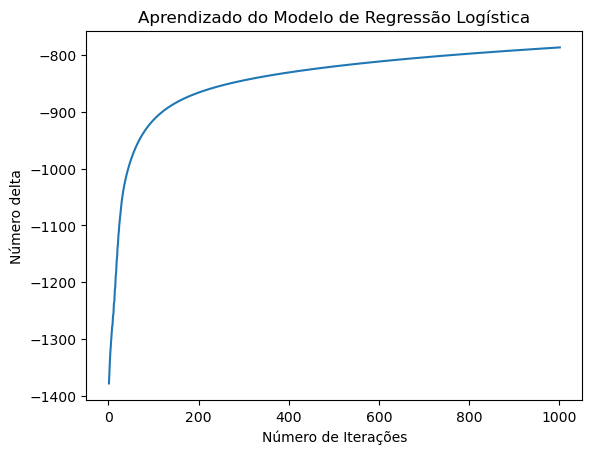

In [22]:
# Plot da aprendizagem do modelo
plt.plot(modelo[2], modelo[1])

# Configura os labels do gráfico
plt.xlabel('Número de Iterações')
plt.ylabel('Número delta')
plt.title('Aprendizado do Modelo de Regressão Logística')

# Visualiza o gráfico
plt.show()

No gráfico vemos que qaunto maior o número de iteração, maior o número de delta e isso significa que o modelo aprendeu perfeitamente a identificar as imagens do banco de dados.

## 7. Teste de Modelo

In [23]:
# Carrega um novo batch de dados
x_teste, y_teste = carrega_dados('test_batch')

In [24]:
# Valores para definir os dados que serão usados
bloco_start = 0
bloco_end = 3

In [25]:
# Formata os dados
x_teste, y_teste = formata_dados(x_teste, y_teste, bloco_start, bloco_end)

In [26]:
# Faz as previsões com o modelo e extrai acertos e erros
acertos, erros = predict(x_teste, y_teste, modelo[0])

In [27]:
# Avalia o modelo
avalia_modelo(acertos, erros, len(y_teste))

Acurácia do Modelo: 81.65%


## 8. Previsões com o modelo treinado

In [29]:
# Função para carregar um novo batch de imagens
def carrega_novas_imagens(filename):
    
    #batch de imagens
    filename = 'cifar-10-batches-py/' + filename
    
    # Loop
    with open(filename, mode = 'rb') as file:
        data = pickle.load(file, encoding = 'bytes')
    
    # Imagens originais
    raw_images = data[b'data']
    raw_images = raw_images.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
    
    # Labels
    labels = np.array(data[b'labels'])
    
    return raw_images, labels

In [30]:
# Executa a função
images, labels = carrega_novas_imagens('test_batch')

In [31]:
# Loop
n_img = []
for i in range(len(labels)):
    if labels[i] == bloco_start or labels[i] == bloco_end:
        n_img.append(images[i])

Esta é a função de distribuição de log-verossimilhança. O eixo x é o número de iterações feitas na fase de treinamento, o eixo y é o valor que está sendo aproximado pela função log-verossimilhança. O objetivo é fazer com que a derivada dessa função se aproxime de 0.

Selecionando algumas imagens classificadas corretamente: 


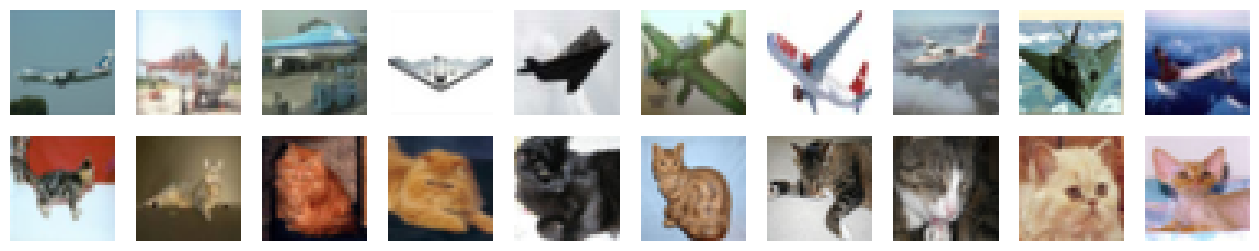

In [32]:
print("Selecionando algumas imagens classificadas corretamente: ")
fig, axes1 = plt.subplots(2,10,figsize=(16,3))
for j in range(2):
    for k in range(10):
        i = random.choice(acertos[j])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(n_img[i:i+1][0])
plt.show()

Selecionando algumas imagens classificadas incorretamente: 


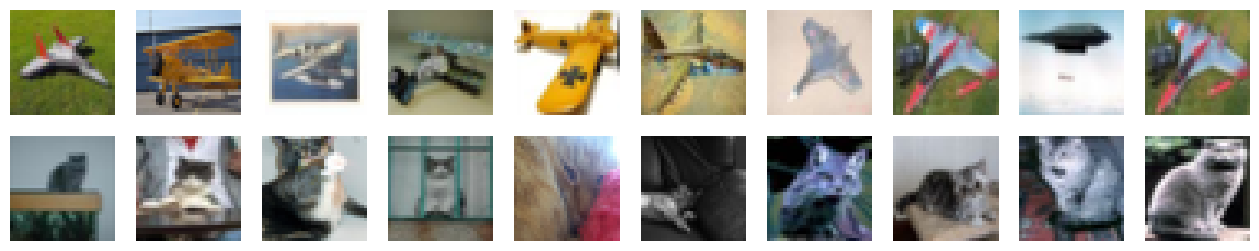

In [33]:
print("Selecionando algumas imagens classificadas incorretamente: ")
fig, axes1 = plt.subplots(2,10,figsize=(16,3))
for j in range(2):
    for k in range(10):
        i = random.choice(erros[j])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(n_img[i:i+1][0])

plt.show()

## 9. Conclusão

O algoritmo teve uma acurácia de 81%, que é um número excelente. Com isso, é possível afirmar que um imagem possui 81% de chance de ser identificada pelo modelo de forma correta. 

A próxima etapa é aumentar essa acurácia com o uso de um framework para reconhecimento de imagens.